## 最尤推定によるガンマ分布のフィッティングについて ##

データのサンプル点をガンマ分布にフィッティングさせる方法として下記のminkaによる方法が知られている。
https://tminka.github.io/papers/minka-gamma.pdf

ここではMinkaの方法における低速な方法でのフィッティングをnumpy, scipyで実装した。

In [1]:
# 下記を予めインポート
import numpy as np
import scipy as sp

import scipy.special as special
import scipy.stats as stats

import matplotlib.pyplot as plt

ガンマ分布は形状母数パラメータ`a`と尺度母数パラメータ`b`を持って下記のように記述される。

$$ p(x|a,b)= \textrm{Ga}(x; a, b) = \frac{x^{a-1}}{\Gamma(a)b^a}\exp \left( - \frac{x}{b} \right) $$

これに従うサンプル点はpythonでは`scipy.stats.gamma`で生成できる。ただし`scipy.stats.gamma`は形状母数パラメータ`a`を明示的に指定し、尺度母数パラメータ`b`はキーワード引数`scale`で与えることとなる。

平均: 0.597, 分散: 0.17909999999999998, 歪度: 1.4177624100166717, 尖度: 3.0150753768844223
cdf(ppf(x)) == x: True
a_hat: 1.8699287082775293, loc_hat: 0.0006612410902254742, scale_hat: 0.32608714461966015


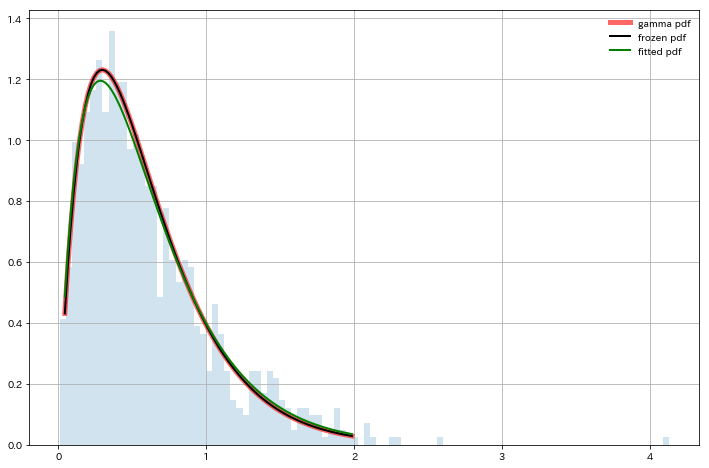

In [2]:
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
# のサンプルコードを改変したもの
a = 1.99
b = 0.3

# パラメータaに対する平均、分散、歪度、尖度を算出
mean, var, skew, kurt = stats.gamma.stats(a, moments='mvsk', scale=b)
print("平均: {0}, 分散: {1}, 歪度: {2}, 尖度: {3}".format(mean, var, skew, kurt))

# 確率密度を計算する点を準備
# ppfは累積密度関数cdfの逆関数に相当するもの、
# 即ち下記では累積確率値が1%の点から99%の点までを100等分している
xs = np.linspace(stats.gamma.ppf(0.01, a, scale=b),
                           stats.gamma.ppf(0.99, a, scale=b), 100)

# ppfがcdfの逆関数となっていることを確認
cdf_values = [0.001, 0.5, 0.999]
ppf_points = stats.gamma.ppf(cdf_values, a, scale=b)
is_close = np.allclose(cdf_values, stats.gamma.cdf(ppf_points, a, scale=b))
print("cdf(ppf(x)) == x: {}".format(is_close))

# 確率密度関数pdfを用いてxsの各点に対する確率密度を計算
ps = stats.gamma.pdf(xs, a, scale=b)

# 確率分布オブジェクトはパラメータを固定するために関数として呼ぶことも可能
rv = stats.gamma(a, scale=b )
ps_fixed = rv.pdf(xs)

# seedを固定してガンマ分布に従う乱数値を1000点生成
seed = 1
rs = stats.gamma.rvs(a, size=1000, scale=b, random_state=seed)

# fittingを実行
# 最尤推定した形状パラメータ(a), 位置パラメータ, スケールパラメータ(b)を返す
a_hat, loc_hat, scale_hat = stats.gamma.fit(rs)
ps_hat = stats.gamma.pdf(xs, a_hat, loc=loc_hat, scale=scale_hat)
print("a_hat: {0}, loc_hat: {1}, scale_hat: {2}".format(a_hat, loc_hat, scale_hat))

# 確率分布およびヒストグラムをプロット
fig = plt.figure(1, figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(xs, ps          , 'r-', lw=5, alpha=0.6, label='gamma pdf')
ax.plot(xs, ps_fixed, 'k-', lw=2, label='frozen pdf')
ax.plot(xs, ps_hat  , 'g-', lw=2, label='fitted pdf')

nbins = 100
ax.hist(rs, density=True, histtype='stepfilled', alpha=0.2, bins=nbins)
ax.legend(loc='best', frameon=False)

ax.grid(True)

途中、`stats.gamma.fit`でガンマ分布からサンプリングした乱数値から最尤推定に基づくパラメータ推定を行っているが、ここではこの最尤推定によるフィッティングは冒頭に記載したMinkaによる方法を用いることで行える。

Minkaの方法による低速なフィッティング方法では以下の文献中の`(8)`式を繰り返し実行することによって形状パラメータ`a`を推定する。

$$ \Psi(a_{n+1}) = \overline{\log{x}} - \log{\overline{x}} + \log{a_n}$$

ここで$\Psi(x)$はディガンマ関数であり、上線は平均を表す。$a_{n+1}$を求めるためには、右辺の値を計算し、これに対するディガンマ関数の逆関数$\Psi^{-1}(x)$の値を下記のように計算することで求めることが可能である。

$$ a_{n+1} = \Psi^{-1}\left(\overline{\log{x}} - \log{\overline{x}} + \log{a_n}\right)$$

このdigamma関数の逆関数の実装は[この記事](http://bariskurt.com/calculating-the-inverse-of-digamma-function/)を参考にした(リンク先のｍatlab実装をpython版として改変した)。

また、尺度パラメータ`b`に関しては上記で推定した`a`を用いて$b=\overline{x}/a`$として推定が可能である。位置パラメータについてはここでは考慮していない。

In [3]:
def inv_digamma(x, niter=3):
    m = float(x >= -2.22)
    y = m * (np.exp(x) + 0.5) + (1.0 - m) * (-1.0 / (x - special.digamma(1)))
    for _ in range(niter):
        y = y - (special.digamma(y) - x) / special.polygamma(1, y)
    return y


def gamma_fit(xs, niter_a=250, a0=1.0):
    mean_xs = np.mean(xs)
    log_mean_xs = np.log(mean_xs)
    mean_log_xs = np.mean(np.log(xs))
    a_hat = a0
    for _ in range(niter_a):
        a_hat = inv_digamma(mean_log_xs - log_mean_xs + np.log(a_hat))
    b_hat = np.mean(xs) / a_hat
    
    return (a_hat, b_hat)

上記実装を用いて実際にフィッティングを行った結果を下記に記す。

a_hat: 1.8772947079419777, b_hat: 0.32516264727354144


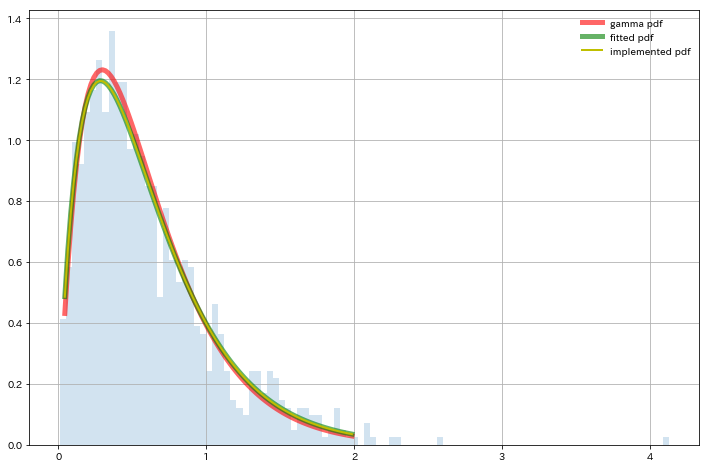

In [4]:
# 実行
a_hat, b_hat = gamma_fit(rs)
print("a_hat: {0}, b_hat: {1}".format(a_hat, b_hat))
my_ps_hat = stats.gamma.pdf(xs, a_hat, scale=b_hat)


# 確率分布およびヒストグラムをプロット
fig = plt.figure(1, figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(xs, ps          , 'r-', lw=5, alpha=0.6, label='gamma pdf')
ax.plot(xs, ps_hat  , 'g-', lw=5, alpha=0.6, label='fitted pdf')
ax.plot(xs, my_ps_hat, 'y-', lw=2, label='implemented pdf')

nbins = 100
ax.hist(rs, density=True, histtype='stepfilled', alpha=0.2, bins=nbins)
ax.legend(loc='best', frameon=False)

ax.grid(True)

`scipy.stats`の`fit`によって推定された結果と自前実装である`gamma_fit`の結果がほとんど同じになっていることが分かる。